In [1]:
import numpy
import torch
from torch.utils.data import DataLoader , Dataset
import cv2
import matplotlib.pyplot as plt
from cfg import *


In [2]:
class Flair_dataset(Dataset):
    def __init__(self, inputs: list, targets: list, transform=None) -> None:
        super().__init__()
        self.inputs = inputs
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self , index : int  , transform = None):
        #是否有辦法用path + file name取用data
        input_img = self.inputs[index]
        target_img = self.targets[index]
        
        in_data , out_data = cv2.imread(input_img) , cv2.imread(target_img)

        if self.transform != None :
            in_data , out_data = self.transform(in_data , out_data)

        #change numpy to torch (typecasting)
        in_data, out_data = torch.from_numpy(in_data).type(torch.float32), torch.from_numpy(out_data).type(torch.float32)

        return in_data , out_data 
        
        
        

        
        
    
        


In [19]:
import os
path_list = os.listdir(non_flair_data)
name_set = set()
for name in path_list :
    name = name.strip('.jpg').strip('.json')
    if name == 'ipynb_checkpoint' :
        continue
    name_set.add(name)
print(name_set)
path_list = os.listdir(non_flair_target)
name_set2 = set()
for name in path_list:
    name = name.strip('.png')
    if name == 'ipynb_checkpoint':
        continue
    name_set2.add(name)
print(name_set2)

if name_set2 == name_set :
    print('success')




{'27931321', '20947834', '21105320', '19425238', '29816081', '25825974', '22296689', '26073373', '12261283', '26082459', '26658418', '27710844', '31406726', '28358688', '13488672', '27103788', '27607264', '33056266', '15525495', '19315335', '15176128', '27472711', '52847319', '18456622', '27237207', '29285707', '29729120', '30732894', '30920239', '31445157', '15552568', '21381973', '31001430', '26434694', '25385854', '30517836', '30871154', '28267864', '31046225', '28248060', '29301889', '17244854', '21372392'}
{'27931321', '20947834', '21105320', '19425238', '29816081', '25825974', '22296689', '26073373', '12261283', '26082459', '26658418', '27710844', '31406726', '28358688', '13488672', '27103788', '27607264', '33056266', '15525495', '19315335', '15176128', '27472711', '52847319', '18456622', '27237207', '29285707', '29729120', '30732894', '30920239', '31445157', '15552568', '21381973', '31001430', '26434694', '25385854', '30517836', '30871154', '28267864', '31046225', '28248060', '2

['./data/PSPF_voc_data/non_PR/Flair/JPEGImages/27931321.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/20947834.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/21105320.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/19425238.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/29816081.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/25825974.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/22296689.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/26073373.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/12261283.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/26082459.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/26658418.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/27710844.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/31406726.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/28358688.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/13488672.jpg', './data/PSPF_voc_data/non_PR/Flair/JPEGImages/27103788.jpg', './data/PSPF_voc_data/n

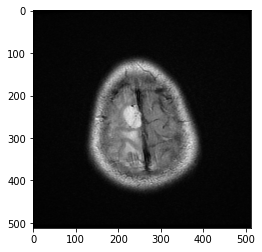

(512, 512, 3)


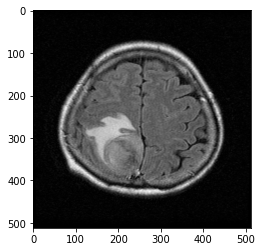

(512, 512, 3)


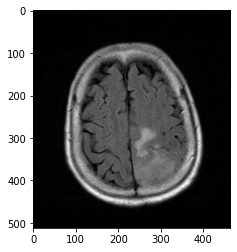

(512, 464, 3)


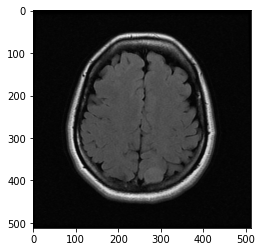

(512, 512, 3)


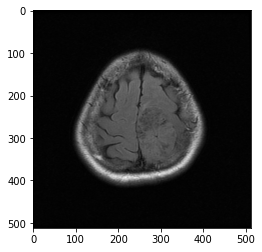

(512, 512, 3)


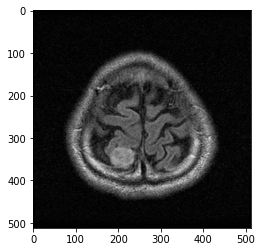

(512, 512, 3)


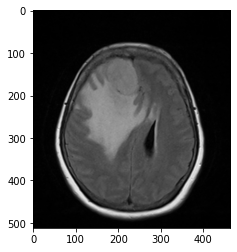

(512, 464, 3)


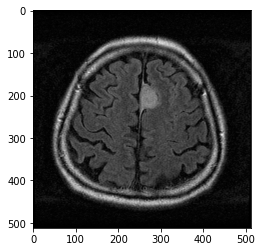

(512, 512, 3)


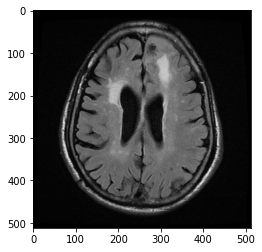

(512, 512, 3)


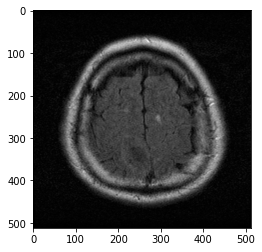

(512, 512, 3)


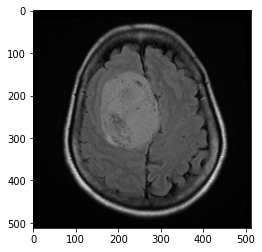

(512, 512, 3)


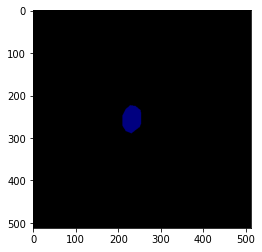

(512, 512, 3)


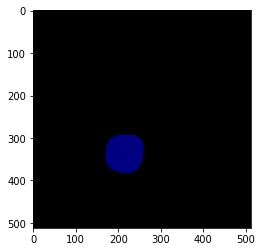

(512, 512, 3)


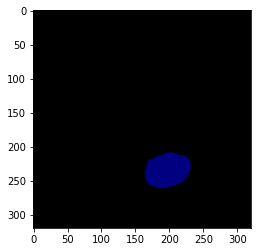

(320, 320, 3)


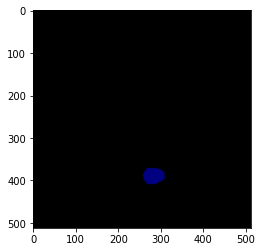

(512, 512, 3)


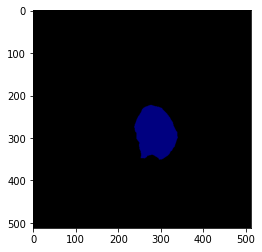

(512, 512, 3)


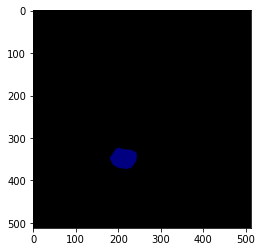

(512, 512, 3)


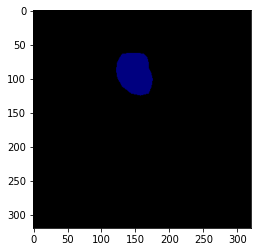

(320, 320, 3)


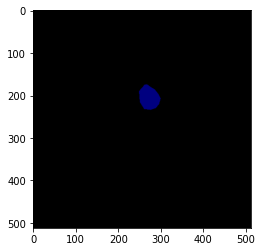

(512, 512, 3)


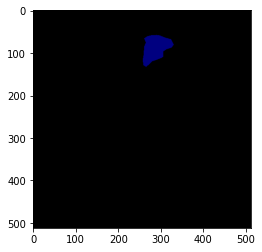

(512, 512, 3)


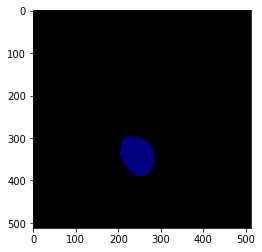

(512, 512, 3)


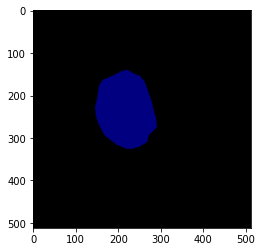

(512, 512, 3)


"\ntrain_dataset = Flair_dataset(train_data_list,\n                             target_data_list ,\n                              transform= None)\ntraining_dataloader = DataLoader(train_dataset,\n                                 batch_size=4,\n                                 shuffle=True)\nfor img1 in train_data_list :\n    img1 = cv2.imread(img1)\n    plt.imshow(img1)\n    plt.show()\n    print(img1.shape)\nfor img2 in target_data_list :\n    img2 = cv2.imread(img2)\n    plt.imshow(img2)\n    plt.show()\n    print(img2.shape)\n        \nx, y = next(iter(training_dataloader))\n\nprint(f'x = shape: {x.shape}; type: {x.dtype}')\nprint(f'x = min: {x.min()}; max: {x.max()}')\nprint(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')\n"

In [21]:

'''
train_data_list = [non_flair_data + '12261283.jpg',
                   non_flair_data + '13488672.jpg', non_flair_data + '15176128.jpg', non_flair_data + '15525495.jpg']
target_data_list = [non_flair_target + '12261283.png',
                    non_flair_target + '13488672.png',  non_flair_target + '15176128.png',  non_flair_target + '15525495.png']
'''
train_data_list = []
target_data_list =[]
for name in name_set :
    train_data_list.append(non_flair_data + name + '.jpg')
    target_data_list.append(non_flair_target + name + '.png')
print(train_data_list)
print(target_data_list)

count , count2 = 0 , 0
for img1 in train_data_list:
    img1 = cv2.imread(img1)
    plt.imshow(img1)
    plt.show()
    print(img1.shape)
    count += 1
    if count > 10 : break
for img2 in target_data_list:
    img2 = cv2.imread(img2)
    plt.imshow(img2)
    plt.show()
    print(img2.shape)
    count2 += 1
    if count2 > 10: break
'''
train_dataset = Flair_dataset(train_data_list,
                             target_data_list ,
                              transform= None)
training_dataloader = DataLoader(train_dataset,
                                 batch_size=4,
                                 shuffle=True)
for img1 in train_data_list :
    img1 = cv2.imread(img1)
    plt.imshow(img1)
    plt.show()
    print(img1.shape)
for img2 in target_data_list :
    img2 = cv2.imread(img2)
    plt.imshow(img2)
    plt.show()
    print(img2.shape)
        
x, y = next(iter(training_dataloader))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')
'''

